# Table of Contents
* [Introduction](#Introduction)
	* [Guiding questions](#Guiding-questions)
	* [Related notebooks](#Related-notebooks)
* [Setup](#Setup)
	* [Imports](#Imports)
	* [Load data](#Load-data)
	* [code](#code)
	* [load](#load)
* [Analysis](#Analysis)
	* [code](#code)
	* [run](#run)
* [Conclusions](#Conclusions)
	* [Key findings](#Key-findings)
	* [Next steps](#Next-steps)


# Introduction

## Guiding questions

* Guiding question:
Can I improve grid extraction by finding largest component first, then extracting contours

## Related notebooks

* **Related notebooks:**  early_table_parse_experiment.ipynb

# Setup

## Imports

In [4]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
import hashlib
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

In [5]:
%%capture
import matplotlib as mpl
import matplotlib.pylab as plt
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)

In [6]:
import os
import cv2

import PIL.Image as Image
import skimage.filters

from urllib.request import url2pathname

In [7]:
%load_ext version_information
%reload_ext version_information
%version_information numpy, matplotlib, pandas, scipy, cv2, skimage, PIL

Software,Version
Python,3.6.1 64bit [GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.42.1)]
IPython,6.0.0
OS,Darwin 16.6.0 x86_64 i386 64bit
numpy,1.12.1
matplotlib,2.0.2
pandas,0.20.1
scipy,0.19.0
cv2,3.2.0
skimage,0.13.0
PIL,4.1.1


# Analysis

## code

In [8]:
def ifa(img_arr):
    return Image.fromarray(img_arr)


def ifb(blobs):
    plt.imshow(blobs, cmap='nipy_spectral')
    _ = plt.axis('off')

    
def random_color():
    import random
    return random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)


def draw_detections(img_path, found_cells):    
    image = cv2.imread(img_path)
    color_counter = 0
    for cell in found_cells:
        start_x = cell[0][0]
        start_y = cell[0][1]
        end_x = cell[1][0]
        end_y = cell[1][1]
        cv2.rectangle(image, (start_x, start_y), (end_x, end_y), color=random_color(), thickness=2)
        color_counter += 1
    return Image.fromarray(image)


In [9]:
def convert_binary_image(binary_image):
    image = binary_image.astype('uint8') * np.ones_like(binary_image) * 255
    return image


def foreground_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh_val = skimage.filters.threshold_li(gray)
    foreground = gray < thresh_val
    return convert_binary_image(foreground)


def connect_and_label_components(foreground_img):
    img = foreground_img
    blobs = img > img.mean()
    labeled_image_components = skimage.measure.label(blobs)
    return labeled_image_components


def find_largest_component(labeled_components):
    regions = skimage.measure.regionprops(labeled_components)
    regions_by_area = sorted(regions, key=lambda x: x.convex_area, reverse=True)
    largest_region = regions_by_area[0]
    return convert_binary_image(labeled_components == largest_region.label)


def cell_from_contour(contour):
    cont = contour.reshape((contour.shape[0], 2))
    bounding_box = (cont[:,:1].min(), cont[:,1:].min()) , (cont[:,:1].max(), cont[:,1:].max())
    return bounding_box

def compute_grid_contours(assumed_grid_mask):
    converted_mask =  assumed_grid_mask * np.ones_like(assumed_grid_mask) * 255
    _, contours, hierarchy = cv2.findContours(converted_mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    hierarchy = hierarchy.reshape(hierarchy.shape[1:])
    child_idxs = hierarchy[:,-1] == 0
    return [cont for idx, cont in enumerate(contours) if child_idxs[idx]]

## run

In [11]:
import glob
hard_image = '/Users/schwenk/wrk/tableparse/data/tricky_tables/unnamed-3.png'
another_image = '/Users/schwenk/wrk/tableparse/data/tricky_tables/unnamed-2.png'
easy_image = '/Users/schwenk/wrk/tableparse/vision-tableparse/examples/sight-word-bingo.png'

output_dir = 'test_cc_output'
test_images = glob.glob('/Users/schwenk/wrk/tableparse/data/test_data/images/*')

In [14]:
# %%time
# for image_to_do in test_images[97:]:
#     test_img = cv2.imread(image_to_do)
#     image_name = os.path.split(image_to_do)[-1]

#     foreground_img = foreground_image(test_img)
#     connected_components = connect_and_label_components(foreground_img)
#     candidate_grid = find_largest_component(connected_components)
#     grid_contours = compute_grid_contours(candidate_grid)

#     bounding_boxes = [cell_from_contour(cont) for cont in grid_contours]

#     cv2.imwrite(os.path.join(output_dir, image_name), test_img)
#     cv2.imwrite(os.path.join(output_dir, image_name.replace('.png', '_grid.png')), candidate_grid)
#     draw_detections(image_to_do, bounding_boxes).save(os.path.join(output_dir,image_name.replace('.png', '_cells.png')))

In [63]:
image_to_do = test_images[110]

image_to_do

'/Users/schwenk/wrk/tableparse/data/test_data/images/table_111.png'

In [64]:
test_img = cv2.imread(image_to_do)
image_name = os.path.split(image_to_do)[-1]

foreground_img = foreground_image(test_img)
connected_components = connect_and_label_components(foreground_img)
candidate_grid = find_largest_component(connected_components)
grid_contours = compute_grid_contours(candidate_grid)

bounding_boxes = [cell_from_contour(cont) for cont in grid_contours]
# grid_cells = [GridCell(cell_from_contour(cont)) for cont in grid_contours]

next and previous contours at the same hierarchical level, the first child contour and the parent contour

In [179]:
timg = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

In [180]:
timg.min()

32

In [182]:
(cv2.add(timg, candidate_grid)).min()

32

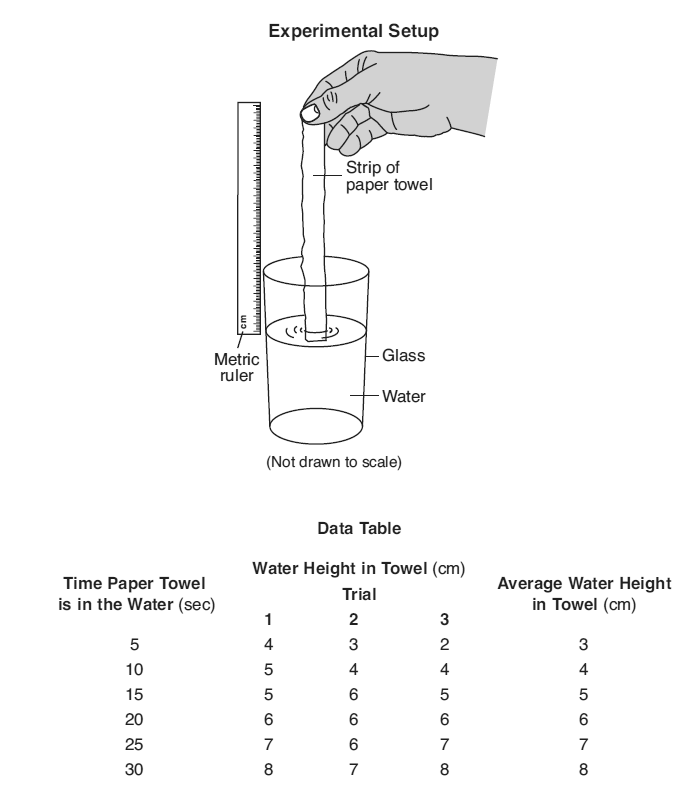

In [183]:
ifa(cv2.add(timg, candidate_grid))

In [129]:
ti_coutns = pd.Series(timg.flatten()).value_counts()
ti_coutns[ti_coutns.index.isin([32, 255])]

255    505087
32      17426
dtype: int64

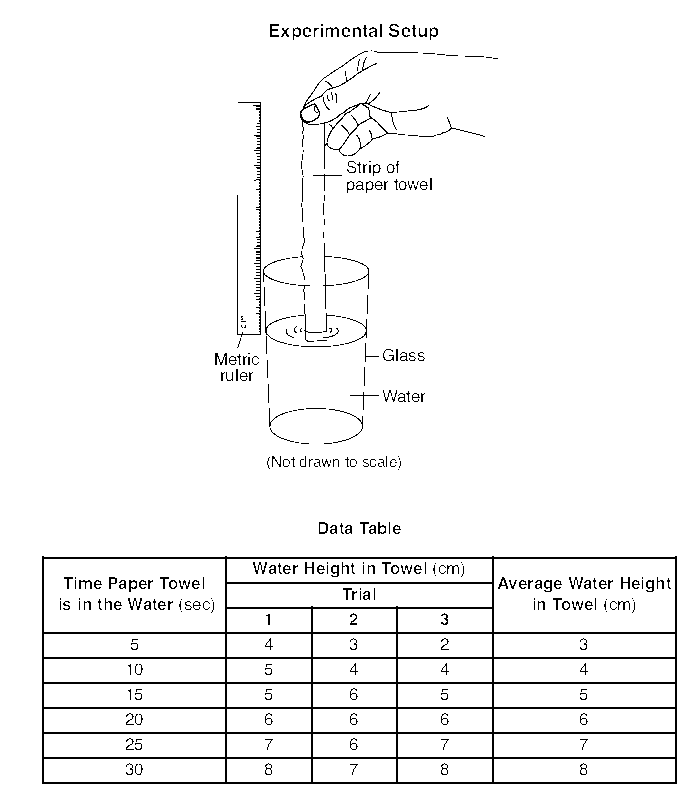

In [145]:
ifa(255 - foreground_img)

In [142]:
pd.Series(foreground_img.flatten()).value_counts()

0      532602
255     22598
dtype: int64

In [122]:
cgc = pd.Series(candidate_grid.flatten()).value_counts()

0      541636
255     13564
dtype: int64

In [125]:
(candidate_grid + timg).min()

31

In [170]:
timg[timg_gray < timg_gray.min() + 2] 

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [169]:
timg[timg_gray < timg_gray.min() + 2].reshape(timg_gray.shape)

ValueError: cannot reshape array of size 17696 into shape (800,694)

In [165]:
pd.Series(timg.flatten()).min()

0

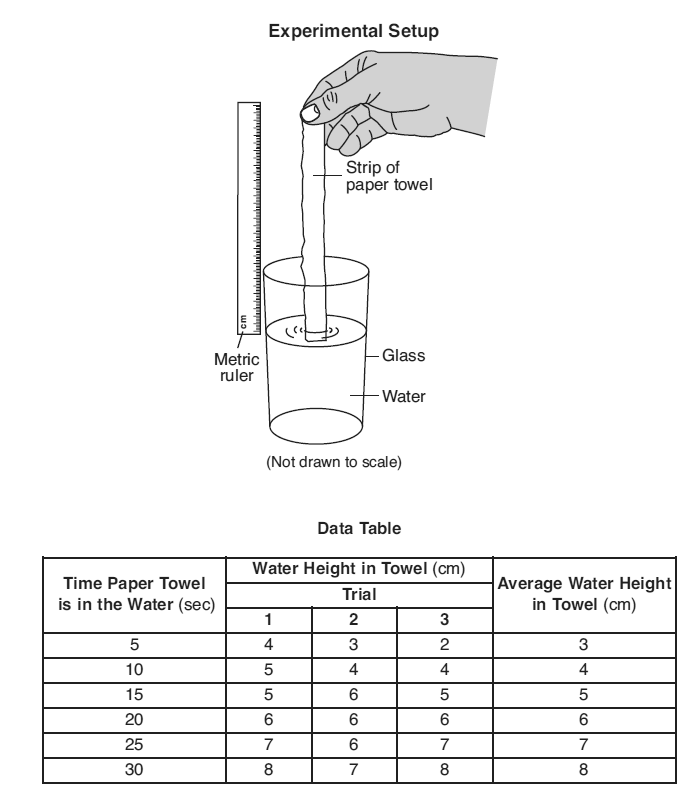

In [149]:
ifa(timg)

In [133]:
agc = pd.Series((candidate_grid + timg).flatten()).value_counts()
agc[agc.index.isin([31, 255])]

255    505087
31      13564
dtype: int64

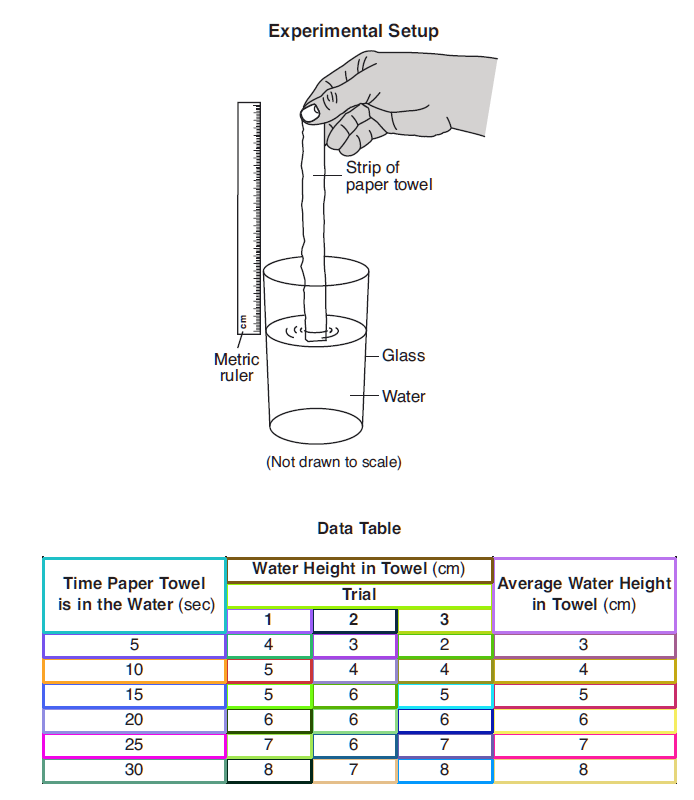

In [28]:
draw_detections(image_to_do, bounding_boxes)

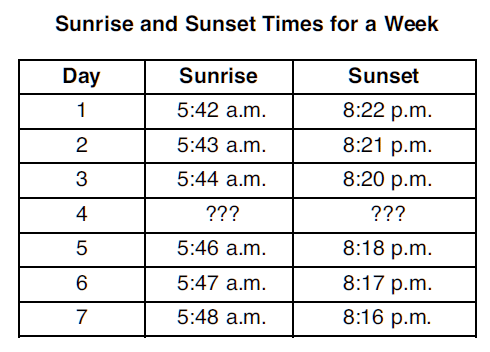

In [726]:
ifa(test_img)

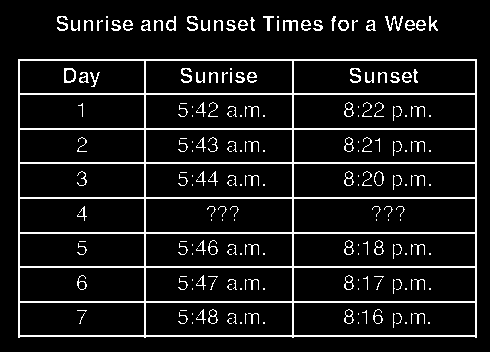

In [727]:
ifa(foreground_img)

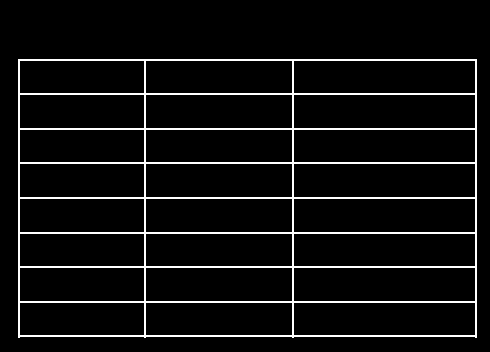

In [728]:
ifa(candidate_grid)

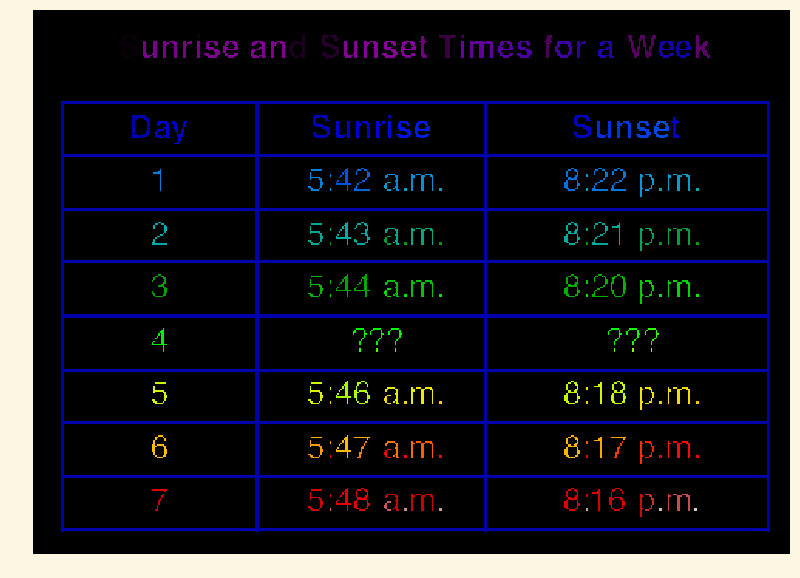

In [729]:
ifb(connected_components)

# match to OCR

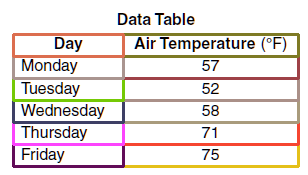

In [1051]:
image_to_do = test_images[97]

test_img = cv2.imread(image_to_do)
image_name = os.path.split(image_to_do)[-1]

foreground_img = foreground_image(test_img)
connected_components = connect_and_label_components(foreground_img)
candidate_grid = find_largest_component(connected_components)
grid_contours = compute_grid_contours(candidate_grid)

bounding_boxes = [cell_from_contour(cont) for cont in grid_contours]
draw_detections(image_to_do, bounding_boxes)

In [190]:
np.argwhere(candidate_grid)

array([[556,  42],
       [556,  43],
       [556, 225],
       ..., 
       [783, 674],
       [783, 675],
       [783, 676]])

In [800]:
test_ocr_img =cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY) + candidate_grid

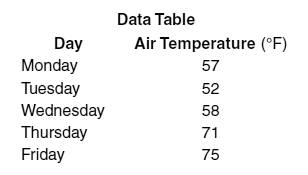

In [801]:
ifa(test_ocr_img)

In [802]:
img_buffer = BytesIO()

In [803]:
ifa(test_ocr_img).save(img_buffer, format="PNG")
img_str = base64.b64encode(img_buffer.getvalue())

In [1108]:
img_str = base64.b64encode(cv2.imencode('.png', test_ocr_img)[1].tostring())

In [1109]:
import base64
from io import BytesIO
import requests

In [1110]:
api_entry_point = 'http://vision-ocr.dev.allenai.org/v1/ocr'
b64_encoded_image = base64.b64encode(test_ocr_img.tostring())
header = {'Content-Type': 'application/json'}
request_data = {
    'image': img_str.decode('utf-8'),
    'mergeBoxes': False,
    'includeMergedComponents': True
}

json_data = json.dumps(request_data)
response = requests.post(api_entry_point, data=json_data, headers=header)
print(response.reason)
json_response = json.loads(response.content.decode())

OK


In [807]:
def query_vision_ocr(image_url, merge_boxes=False, include_merged_components=False, as_json=True):
    b64_encoded_image = base64.b64encode(test_ocr_img)
    api_entry_point = 'http://vision-ocr.dev.allenai.org/v1/ocr'
    b64_encoded_image = base64.b64encode(test_ocr_img)

    header = {'Content-Type': 'application/json'}
    request_data = {
        'image': base_64_img,
        'mergeBoxes': merge_boxes,
        'includeMergedComponents': include_merged_components
    }

    json_data = json.dumps(request_data)
    response = requests.post(api_entry_point, data=json_data, headers=header)
    print(response.reason)
    json_response = json.loads(response.content.decode())
    if as_json:
        response = json_response
    return response

In [1031]:
class Box(object):
    
    def __init__(self):
        self.upper_x = 0
        self.lower_x = 0
        self.upper_y = 0
        self.lower_y = 0
        self.ocr = None
            
    def __repr__(self):
        return ', '.join(map(str, [self.ocr, self.u_x(), self.l_x(), self.u_y(), self.l_y()]))
        
    def u_x(self):
        return self.upper_x
    
    def l_x(self):
        return self.lower_x
    
    def u_y(self):
        return self.upper_y
    
    def l_y(self):
        return self.lower_y
    
    def area(self):
        return (self.u_x() - self.l_x()) * (self.u_y() - self.l_y())
    
    def text(self):
        return self.ocr
    
    
class OcrBox(Box):
    
    def __init__(self, detection):
        rect = detection['rectangle']
        self.upper_x = rect[1]['x']
        self.lower_x = rect[0]['x']
        self.upper_y = rect[1]['y']
        self.lower_y = rect[0]['y']
        self.ocr = detection['value']
        

        
class GridCell(Box):
    
    def __init__(self, coords):
        self.upper_x = coords[1][0]
        self.lower_x = coords[0][0]
        self.upper_y = coords[1][1]
        self.lower_y = coords[0][1]
        self.ocr = ""
        
    def assign_detection(self, ocr):
        self.ocr = ocr

In [1027]:
def boxes_overlap(detected_box, grid_box, thresh=0.9):
    dx = min(detected_box.u_x(), grid_box.u_x()) - max(detected_box.l_x(), grid_box.l_x())
    dy = min(detected_box.u_y(), grid_box.u_y()) - max(detected_box.l_y(), grid_box.l_y())
    if (dx > 0) and (dy > 0):
        intersection_area = dx * dy
        return float(intersection_area) / min(detected_box.area(), grid_box.area()) > thresh
    else:
        return False
    
    
def assign_ocr_to_cells(detected_boxes, grid_boxes, thresh=0.5):
    for db in detected_boxes:
        for gb in grid_boxes:
            if boxes_overlap(db, gb, thresh):
                gb.assign_detection(db.text())
    return 

In [1102]:
def draw_detections_w_text(img_path, grid_cells):    
    image = cv2.imread(img_path)
    color_counter = 0
    for cell in grid_cells:
        cv2.rectangle(image, (cell.l_x(), cell.l_y()), (cell.u_x(), cell.u_y()), color=random_color(), thickness=2)
        cv2.putText(image, cell.text(), (cell.l_x(), cell.u_y()), cv2.FONT_HERSHEY_PLAIN, 0.8, (0,0,255), 2)
        color_counter += 1
    return Image.fromarray(image)

In [1094]:
ocr_detections = [OcrBox(det) for det in json_response['detections']]

In [1095]:
grid_cells = [GridCell(cell) for cell in bounding_boxes]

In [1096]:
matches = assign_ocr_to_cells(ocr_detections, grid_cells)

In [1097]:
matches

In [1098]:
ocr_detections

[Data Table, 195, 118, 26, 13,
 Day, 84, 54, 53, 37,
 Air Temperature (OF), 287, 134, 53, 37,
 Monday, 78, 21, 76, 56,
 57, 220, 202, 72, 60,
 Tuesday, 81, 21, 99, 81,
 52, 220, 202, 96, 82,
 Wednesday, 105, 21, 120, 104,
 58, 220, 201, 118, 104,
 Thursday, 87, 21, 142, 125,
 71, 218, 201, 140, 126,
 Friday, 65, 22, 165, 146,
 75, 221, 202, 162, 147]

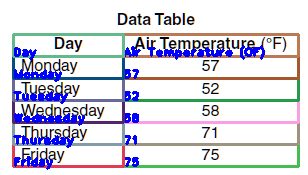

In [1103]:
draw_detections_w_text(image_to_do, grid_cells)

In [1104]:
grid_cells

[75, 298, 123, 166, 144,
 Friday, 123, 13, 166, 144,
 71, 298, 123, 144, 122,
 Thursday, 123, 13, 144, 122,
 58, 298, 123, 122, 100,
 Wednesday, 123, 13, 122, 100,
 52, 298, 123, 100, 78,
 Tuesday, 123, 13, 100, 78,
 57, 298, 123, 78, 56,
 Monday, 123, 13, 78, 56,
 Air Temperature (OF), 298, 123, 56, 34,
 Day, 123, 13, 56, 34]

# Conclusions

Using connected components to find the grid is promising. It should work for nearly all Aristo Tables